In [1]:
from IPython.display import Audio
import random
import matplotlib.pyplot as plt
import tempfile
import numpy as np
import os

In [2]:
import torch
from torch import optim
from torch.nn.functional import cross_entropy
import torchaudio
import torchaudio.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

In [4]:
import ray
from ray import tune
from ray import train
from ray.train import Checkpoint
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

In [5]:
from src.custom_audio_dataset import CustomAudioDataset
from src.models import CnnMFCC
from src.utils import pad_collate_fn, plot_spectrogram, dataloader_from_filter
from src.datasets import get_data_path
from src import custom_layers
from src.hesitation import coraa_filters

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_EPOCH = 15

TRAIN_SIZE = 0.6
TEST_FROM_VAL_SIZE = 0.5

SAMPLE_RATE = 16_000
MAX_SECONDS_DURATION = 10

MAX_FEATURES_IN = SAMPLE_RATE * MAX_SECONDS_DURATION

DEVICE

'cuda'

In [7]:
annotations_file_path, data_dir_path = get_data_path("hesitation_dev")
annotations_file_path, data_dir_path

('/home/glucas11/projects/repos/speech_feedback/temp_datasets/hesitation_dev/annotations.csv',
 '/home/glucas11/projects/repos/speech_feedback/temp_datasets/hesitation_dev')

In [8]:
train_data_transform = torch.nn.Sequential(
    # custom_layers.RandomPitchShiftLayer(p=0.001, sample_rate=SAMPLE_RATE, min_steps=-5, max_steps=5), # too heavy
    # custom_layers.ReverberationLayer(1,400), # not working yet
    custom_layers.PadOrTruncateLayer(MAX_FEATURES_IN),
    custom_layers.NoiseLayer(p=0.5, noise_factor=0.05),
)
data_transform = torch.nn.Sequential(
    custom_layers.PadOrTruncateLayer(MAX_FEATURES_IN),
)

In [9]:
filters_func = {
    "filter0": coraa_filters.filter0,
    "filter1": coraa_filters.filter1,
    "filter2": coraa_filters.filter2,
}

models_arch = {
    "CnnMFCC": CnnMFCC,
}

In [10]:
def train_func(model, optimizer, dataloader):
	model.train()
	losses = []
	pred_np = []
	target_np = []
	for batch_idx, (data, target) in enumerate(dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		loss = cross_entropy(logits, target)
		losses.append(loss.item())
		loss.backward()
		optimizer.step()
		
		preds = torch.max(logits, dim=1).indices
		pred_np.append(preds.detach().cpu().numpy())
		target_np.append(target.detach().cpu().numpy())
	
	pred_np = np.concatenate(pred_np)
	target_np = np.concatenate(target_np)

	return {
		"mean_loss": sum(losses) / len(losses),
		"accuracy": accuracy_score(target_np, pred_np),
		"f1_score": f1_score(target_np, pred_np),
		# "confusion_matrix": confusion_matrix(target_np, pred_np),
	}

def validate_func(model, dataloader):
	model.eval()
	
	losses = []
	pred_np = []
	target_np = []
	with torch.no_grad():
		for batch_idx, (data, target) in enumerate(dataloader):
			data, target = data.to(DEVICE), target.to(DEVICE)
			logits = model(data)
			loss = cross_entropy(logits, target)
			losses.append(loss.item())
			
			preds = torch.max(logits, dim=1).indices
			pred_np.append(preds.detach().cpu().numpy())
			target_np.append(target.detach().cpu().numpy())

	pred_np = np.concatenate(pred_np)
	target_np = np.concatenate(target_np)

	return {
		"mean_loss": sum(losses) / len(losses),
		"accuracy": accuracy_score(target_np, pred_np),
		"f1_score": f1_score(target_np, pred_np),
	}

In [11]:
def train_hesitation(config:dict, max_epochs=30, tunning=True):
	filter_func = filters_func[config["coraa_filter_func"]]
	train_dataloader, val_dataloader, test_dataloader = dataloader_from_filter(
		annotations_file_path=annotations_file_path,
		data_dir_path=data_dir_path,
		filter=filter_func,
		target_column_name="has_hesitation",
		train_data_transform=train_data_transform,
		data_transform=data_transform,
		train_size=0.6,
		test_from_val_size=0.5
	)
	model_architecture = models_arch[config['model_architecture']]
	model = model_architecture(n_classes=2, sample_rate=SAMPLE_RATE, max_audio_length_seconds=MAX_SECONDS_DURATION, dropout=config['dropout'])
	model = model.to(DEVICE)

	optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

	# early_stopping_patience = 5  # Number of epochs to wait before stopping
	scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3)
	for i in range(max_epochs):
		train_log = train_func(model, optimizer, train_dataloader)
		val_log = validate_func(model, val_dataloader)
		
		scheduler.step(val_log['mean_loss'])

		if tunning:
			with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
				checkpoint = None
				if (i + 1) % max_epochs == 0 and (val_log["mean_loss"] < 0.4):
					# This saves the model to the trial directory
					torch.save(
						model.state_dict(),
						os.path.join(temp_checkpoint_dir, "model.pth")
					)
					checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

				# Send the current training result back to Tune
				train.report(
					{
						"train_mean_loss": train_log["mean_loss"],
						"train_accuracy": train_log["accuracy"],
						"train_f1_score": train_log["f1_score"],
						"val_mean_loss": val_log["mean_loss"],
						"val_accuracy": val_log["accuracy"],
						"val_f1_score": val_log["f1_score"],
					},
					checkpoint=checkpoint
				)
		else:
			print("-"*10, f"epoch: {i+1}/{max_epochs}","-"*10)
			print(f"train: {train_log}\nval: {val_log}")
	if not tunning:
		return {
			"model": model,
			"log": {
				"train": train_log,
				"val": val_log,
			},
		}


In [12]:
max_cpus = os.cpu_count()
max_gpus = torch.cuda.device_count()
max_cpus, max_gpus

config = {
    "dropout": tune.uniform(0.0, 1.0),
    "coraa_filter_func": tune.choice(filters_func.keys()),
    "learning_rate":  tune.loguniform(1e-5, 1e-0),
	"weight_decay": tune.loguniform(1e-6, 1e-2),
    "model_architecture": tune.choice(models_arch.keys()),
}

metric = "val_mean_loss"
mode = "min"

optuna_search = OptunaSearch(
	metric=metric,
	mode=mode,
	# points_to_evaluate = curr_best_params,
)

asas_scheduler = ASHAScheduler(
	time_attr='training_iteration',
	metric=metric,
	mode=mode,
	max_t=10,
	grace_period=1,
	reduction_factor=3,
	brackets=2
)

In [13]:
trainable_with_resources = tune.with_resources(train_hesitation, {"cpu": max_cpus, "gpu": max_gpus})

tuner = tune.Tuner(
	trainable_with_resources,
	tune_config=tune.TuneConfig(
		num_samples=20,
		search_alg=optuna_search,
		scheduler=asas_scheduler
	),
	param_space=config,
)
results = tuner.fit()

(train_hesitation pid=69703) /home/glucas11/projects/repos/speech_feedback/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
(train_hesitation pid=69703)   warnings.warn(
(train_hesitation pid=69990) /home/glucas11/projects/repos/speech_feedback/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
(train_hesitation pid=69990)   warnings.warn(
(train_hesitation pid=70210) /home/glucas11/projects/repos/speech_feedback/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the val

In [14]:
results.get_dataframe().to_csv("raytune_results.csv")

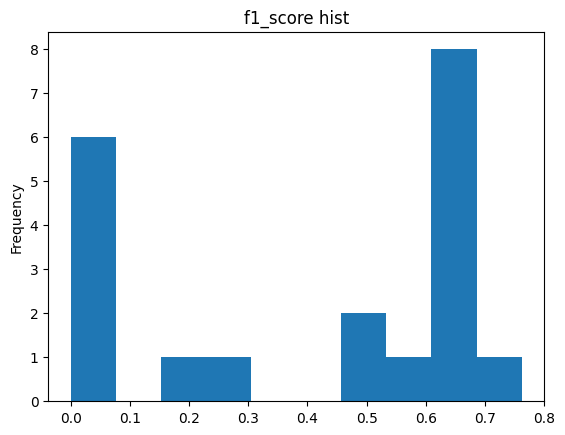

In [16]:
df_results = results.get_dataframe()
scores = df_results['val_f1_score'].plot(kind='hist', title='f1_score hist')